In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('diabetes_prediction_dataset.csv')

df['smoking_history'] = df['smoking_history'].replace('ever', 'never')
# Fixing the 'ever' value to 'never' for consistency
df['smoking_history'] = df['smoking_history'].replace('not current', 'former')
# Fixing the 'not current' value to 'former' for consistency

df.replace('No Info', np.nan, inplace=True)
#Replacing 'No Info' with NaN for better handling of missing values


df = pd.get_dummies(df, columns=['smoking_history'], dummy_na=False)
#One-hot encoding the 'smoking_history' column

df = pd.get_dummies(df, columns=['gender'], drop_first=True)



# Assuming df is already loaded and cleaned
# Make sure your target column is named 'diabetes' or adjust accordingly

df['bmi_was_27_32'] = (df['bmi'] == 27.32).astype(int)

#df['combined1']=df['HbA1c_level']**1.5 * df['blood_glucose_level']
#df['combined2']=df['bmi'] * df['age']**1.5


In [2]:
from sklearn.utils.class_weight import compute_class_weight
# Prepare Data
X = df.drop(columns='diabetes')
y = df['diabetes']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Class weights for imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Define the Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  tf.keras.metrics.AUC(name='PR-AUC', curve='PR'),
                  tf.keras.metrics.Recall(name='Recall'),
                  tf.keras.metrics.Precision(name='Precision')
              ])

# Train with EarlyStopping + Class Weight
early_stop = EarlyStopping(monitor='val_AUC', patience=5, restore_best_weights=True, mode='max')

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop],
                    class_weight=class_weight_dict,
                    verbose=1)

# Predict probabilities
y_proba = model.predict(X_test).ravel()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - PR-AUC: 0.6296 - Precision: 0.2950 - Recall: 0.8443 - loss: 0.3735 - val_PR-AUC: 0.8160 - val_Precision: 0.3824 - val_Recall: 0.9092 - val_loss: 0.2608
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: PR-AUC,Precision,Recall,loss,val_PR-AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - PR-AUC: 0.7849 - Precision: 0.3785 - Recall: 0.8940 - loss: 0.2618 - val_PR-AUC: 0.8199 - val_Precision: 0.3943 - val_Recall: 0.9128 - val_loss: 0.2574
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - PR-AUC: 0.8001 - Precision: 0.3983 - Recall: 0.8998 - loss: 0.2460 - val_PR-AUC: 0.8277 - val_Precision: 0.4183 - val_Recall: 0.9026 - val_loss: 0.2232
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - PR-AUC: 0.8101 - Precision: 0.4014 - Recall: 0.8867 - loss: 0.2411 - val_PR-AUC: 0.8388 - val_Precision: 0.4228 - val_Recall: 0.9172 - val_loss: 0.2137
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - PR-AUC: 0.8324 - Precision: 0.4201 - Recall: 0.9078 - loss: 0.2282 - val_PR-AUC: 0.8493 - val_Precision: 0.4132 - val_Recall: 0.9223 - val_loss: 0.2229
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - PR-AUC: 0.8433 - Precision: 0.4169 - Recall: 0.9088 - loss: 0.2138 - val_PR-AUC: 0.8593 - val_Precision: 0.4295 - val_Recal

Best Threshold for F1: {best_thresh:.3f}
Classification Report (F1-Optimized):
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       0.97      0.70      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000

AUC: 0.9777179565835719


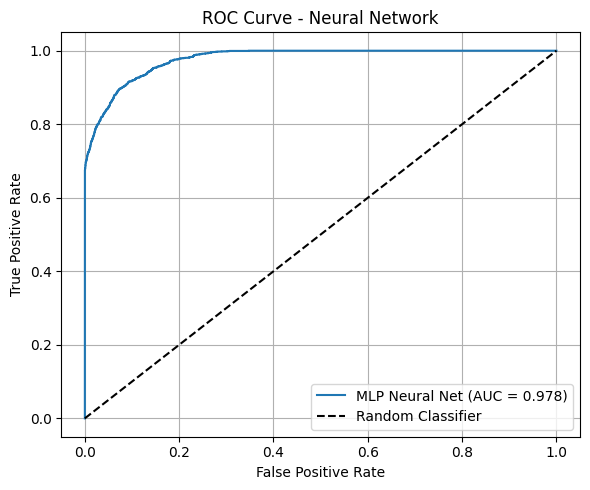

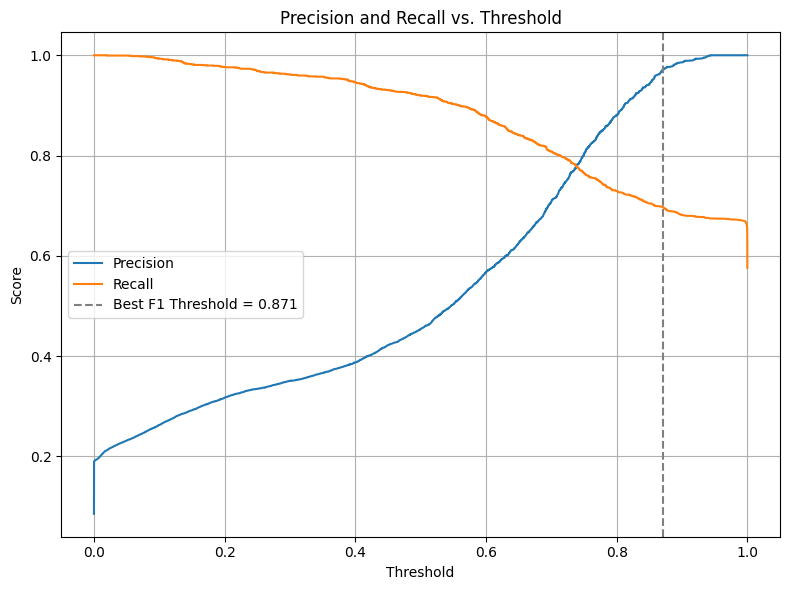

In [8]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Tune threshold for best F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1)
best_thresh = thresholds[best_idx]
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
print("Best Threshold for F1: {best_thresh:.3f}")
print("Classification Report (F1-Optimized):\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'MLP Neural Net (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision & Recall vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=best_thresh, color='gray', linestyle='--', label=f'Best F1 Threshold = {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import average_precision_score

# y_test = true labels
# y_proba = predicted probabilities for the positive class

pr_auc = average_precision_score(y_test, y_proba)
print(f"PR-AUC: {pr_auc:.3f}")

PR-AUC: 0.883


Depending on the applications, we may want to ensure that recall is as close to one as possible to catch almost all diabetes cases.
This would result in a low precision, meaning many false positives. But if further testing is expected, then false positives is not a serious as false negatives

It is near impossible to get a high recall and high precision score with such mechical data at one timestamp.